## Predict housing prices from data patterns
in a *Kaggle* database with information from houses in Ames, Iowa containing:
* 80 descriptive variables
    * 37 numerical variables
    * 43 categorical variables
    
**Objective:** reduce prediction errors as much as possible using **XGBoost** models (Gradient Boosted Decision Trees)

**Author:** Leonardo Espin.

Licensing: This code is distributed under the Mozilla Public License Version 2.0. Date: 09/28/2018

In [2]:
# Loading libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics

In [10]:
import matplotlib.pylab as plt
#set matplotlib options
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

1. Load data

In [6]:
#Dataset file has to be downloaded from Kaggle after creating an account
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')
print(train.shape)
train.head()#shows the first few rows

(1460, 237)


,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,PoolQC_missing,MiscFeature_missing,...,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_missing,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_missing,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_missing,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_missing,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_missing,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,1,1,1,1,7,5,2003,2003,196.0,706.0,1,0.0,150.0,856.0,1,1,856,854,0,1710,1.0,0.0,2,1,3,1,8,1,0,2003.0,2.0,548.0,1,1,0,61,0,0,0,0,0,2,2008,208500.0,1,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,1,1,1,1,1,6,8,1976,1976,0.0,978.0,1,0.0,284.0,1262.0,1,1,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1,1976.0,2.0,460.0,1,1,298,0,0,0,0,0,0,5,2007,181500.0,1,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,60,68.0,11250,1,0,1,1,1,7,5,2001,2002,162.0,486.0,1,0.0,434.0,920.0,1,1,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,1,2001.0,2.0,608.0,1,1,0,42,0,0,0,0,0,9,2008,223500.0,1,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,1,0,1,1,1,7,5,1915,1970,0.0,216.0,1,0.0,540.0,756.0,1,1,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1,1998.0,3.0,642.0,1,1,0,35,272,0,0,0,0,2,2006,140000.0,1,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,1,0,1,1,1,8,5,2000,2000,350.0,655.0,1,0.0,490.0,1145.0,1,1,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,1,2000.0,3.0,836.0,1,1,192,84,0,0,0,0,0,12,2008,250000.0,1,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


  * Set target and predictor variables

In [7]:
target='SalePrice'
predictors =list(train.columns)
predictors.remove(target)

### Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. perform cross validation using the xgboost library
5. update `n_estimators` using results of cv
6. plot Feature Importance 

In [8]:
def modelfit(alg,dtrain,predictors,target,useTrainCV=True,cv_folds=5,early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()#dict with all parameters passed
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)#data structure used by XGBoost
        #command below performs cross validation
        cvresult = xgb.cv(xgb_param,xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='mae',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])#sets 'n_estimators' from result of CV 
        print('Cross-val results: \'n_estimators\' = {}'.format(cvresult.shape[0]))
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mae')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report" )
    print("Mean Absolute Error : {:.2f}".format(metrics.mean_absolute_error(dtrain[target].values, dtrain_predictions)))    

    #Plot feature importance
    feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
    feat_imp[0:40].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

  * set a default regressor

Cross-val results: 'n_estimators' = 336

Model Report
Mean Absolute Error : 6594.07


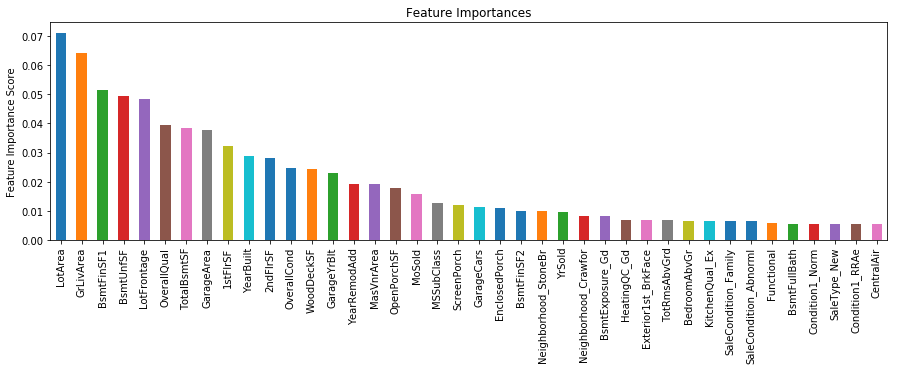

In [11]:
xgb1 = XGBRegressor( #classifier because of binary targer variable
        learning_rate =0.1, #default value (high)
        n_estimators=1000,  #NOT default (100)
        max_depth=3,        #default (3)
        min_child_weight=1, #default
        gamma=0,            #default
        subsample=0.8,      #NOT default (1)
        colsample_bytree=0.8,#NOT default (1)
        nthread=4,
        scale_pos_weight=1, #default
        random_state=27)    #Random number seed

modelfit(xgb1,train,predictors,target)

## Parameter optimization:
### 1. Tree-based parameters
* `max_depth` and `min_child_weight`

In [65]:
#Grid seach on max_depth and min_child_weight
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=336, max_depth=3,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=336,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [61]:
#the grid_scores_ attribute will be deprecated, should use cv_results_ instead, but
#the presentation of results of grid_scores_ is much cleaner
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15484.79708, std: 1074.84934, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -15702.89041, std: 1355.92201, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -15487.65585, std: 1197.91344, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -15497.38374, std: 1026.20659, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -15527.83142, std: 1236.90529, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -15640.04951, std: 1225.97808, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -15840.95804, std: 1044.13019, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -15704.10170, std: 1332.15795, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -15863.88963, std: 1091.39407, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -16232.74770, std: 995.13063, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -15857.43664, std: 1298.21375, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -16080.53468, std: 1190.2

In [92]:
#use a finer grid of search, since the default values were selected
param_test2 = {
    'max_depth':[3,4],
    'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=336, max_depth=3,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test2, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=336,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 4], 'min_child_weight': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [93]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15484.79708, std: 1074.84934, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -15260.90001, std: 1019.63314, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -15280.12837, std: 1180.65862, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -15511.07460, std: 1159.35929, params: {'max_depth': 4, 'min_child_weight': 2}],
 {'max_depth': 3, 'min_child_weight': 2},
 -15260.90000802654)

* Tunning `gamma`

In [73]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]#0,1/10,2/10,...1/2
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=336, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test3, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=336,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [74]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15260.90001, std: 1019.63314, params: {'gamma': 0.0},
  mean: -15260.90001, std: 1019.63314, params: {'gamma': 0.1},
  mean: -15260.90001, std: 1019.63314, params: {'gamma': 0.2},
  mean: -15260.90001, std: 1019.63314, params: {'gamma': 0.3},
  mean: -15260.90001, std: 1019.63314, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -15260.90000802654)

* Re-calibrating number of boosting rounds for new parameters

Cross-val results: 'n_estimators' = 379

Model Report
Mean Absolute Error : 6173.54


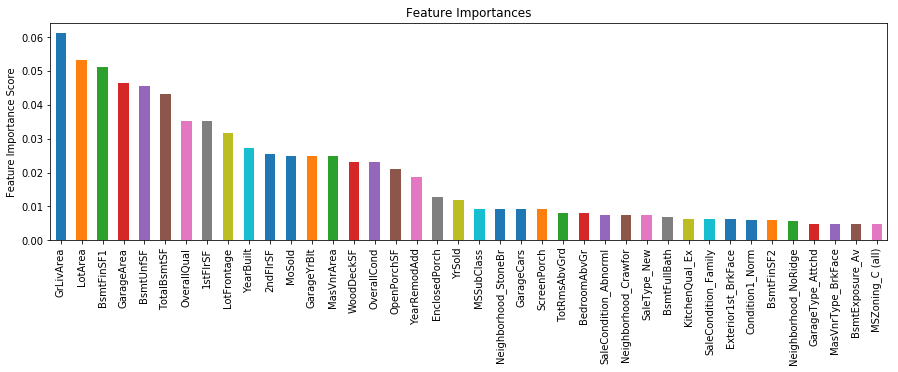

In [82]:
xgb2 = XGBRegressor( #classifier because of binary targer variable
        learning_rate =0.1, #default value (high)
        n_estimators=1000,  #NOT default (100)
        max_depth=3,        #OPTIMIZED 
        min_child_weight=2, #OPTIMIZED
        gamma=0,            #OPTIMIZED 
        subsample=0.8,      #NOT default (1)
        colsample_bytree=0.8,#NOT default (1)
        nthread=4,
        scale_pos_weight=1, #default
        random_state=27)    #Random number seed

modelfit(xgb2,train,predictors,target)

* Tunning `subsample` and `colsample_bytree`

In [83]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],#6/10,...,1
    'colsample_bytree':[i/10.0 for i in range(6,10)]#6/10,...,1
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [84]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15063.27466, std: 672.46297, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -15420.51370, std: 1235.36295, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -15516.53440, std: 1186.95401, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -15118.33280, std: 1307.52746, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -15217.53114, std: 739.07227, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -15258.50702, std: 1266.81362, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -15362.46552, std: 1073.16346, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -15189.78263, std: 1094.56220, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -15395.44503, std: 790.69863, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -15123.36351, std: 803.93882, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -15246.22299, std: 1002.65840, params: {'colsample_bytree': 0.8, 'subsample'

* repeat search with a smaller lower bound:

In [85]:
param_test4 = {
    'subsample':[i/10.0 for i in range(3,6)],
    'colsample_bytree':[i/10.0 for i in range(3,6)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.3, 0.4, 0.5], 'colsample_bytree': [0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [86]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -16257.17346, std: 916.08998, params: {'colsample_bytree': 0.3, 'subsample': 0.3},
  mean: -15472.02864, std: 1006.04700, params: {'colsample_bytree': 0.3, 'subsample': 0.4},
  mean: -15076.93605, std: 1336.42243, params: {'colsample_bytree': 0.3, 'subsample': 0.5},
  mean: -16125.16558, std: 781.76855, params: {'colsample_bytree': 0.4, 'subsample': 0.3},
  mean: -15498.73959, std: 1124.77312, params: {'colsample_bytree': 0.4, 'subsample': 0.4},
  mean: -15187.39092, std: 1383.71475, params: {'colsample_bytree': 0.4, 'subsample': 0.5},
  mean: -16179.71660, std: 1094.50353, params: {'colsample_bytree': 0.5, 'subsample': 0.3},
  mean: -15146.13760, std: 1267.46715, params: {'colsample_bytree': 0.5, 'subsample': 0.4},
  mean: -15299.25862, std: 1033.33019, params: {'colsample_bytree': 0.5, 'subsample': 0.5}],
 {'colsample_bytree': 0.3, 'subsample': 0.5},
 -15076.936049871574)

In [95]:
param_test4 = {
    'colsample_bytree':[i/10.0 for i in range(1,4)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.5, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test4, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [96]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15904.39744, std: 1321.34684, params: {'colsample_bytree': 0.1},
  mean: -15406.34399, std: 1289.25745, params: {'colsample_bytree': 0.2},
  mean: -15076.93605, std: 1336.42243, params: {'colsample_bytree': 0.3}],
 {'colsample_bytree': 0.3},
 -15076.936049871574)

### 2. Regularization parameters
* tune `reg_alpha` and `reg_lambda`

In [98]:
param_test5 = {
    'reg_alpha':[1e-5,1e-2,0.1, 1,10,100],
    'reg_lambda':[1,10,100]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.5, colsample_bytree=0.3,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test5, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [99]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -15076.93581, std: 1336.42232, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: -15759.67539, std: 1285.77355, params: {'reg_alpha': 1e-05, 'reg_lambda': 10},
  mean: -16008.74491, std: 1162.71497, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: -15076.93575, std: 1336.42209, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: -15759.67476, std: 1285.77339, params: {'reg_alpha': 0.01, 'reg_lambda': 10},
  mean: -16008.74491, std: 1162.71498, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: -15076.93528, std: 1336.42232, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: -15759.67585, std: 1285.77352, params: {'reg_alpha': 0.1, 'reg_lambda': 10},
  mean: -16008.74555, std: 1162.71492, params: {'reg_alpha': 0.1, 'reg_lambda': 100},
  mean: -15110.80631, std: 1303.16748, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -15759.67526, std: 1285.77172, params: {'reg_alpha': 1, 'reg_lambda': 10},
  mean: -16008.74734, std: 1162.71523, params: {'reg_alpha': 

In [100]:
param_test5 = {
    'reg_alpha':[100,500,1000],
    'reg_lambda':range(1,10)
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.5, colsample_bytree=0.3,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test5, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [100, 500, 1000], 'reg_lambda': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [101]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -14986.84864, std: 1350.64205, params: {'reg_alpha': 100, 'reg_lambda': 1},
  mean: -14981.34600, std: 1308.31745, params: {'reg_alpha': 100, 'reg_lambda': 2},
  mean: -14984.01695, std: 1258.42534, params: {'reg_alpha': 100, 'reg_lambda': 3},
  mean: -15216.92656, std: 1373.96131, params: {'reg_alpha': 100, 'reg_lambda': 4},
  mean: -15359.50089, std: 1193.30040, params: {'reg_alpha': 100, 'reg_lambda': 5},
  mean: -15466.11520, std: 1580.28771, params: {'reg_alpha': 100, 'reg_lambda': 6},
  mean: -15603.09789, std: 1241.25705, params: {'reg_alpha': 100, 'reg_lambda': 7},
  mean: -15645.13385, std: 1571.17763, params: {'reg_alpha': 100, 'reg_lambda': 8},
  mean: -15659.43627, std: 1121.78738, params: {'reg_alpha': 100, 'reg_lambda': 9},
  mean: -14902.08216, std: 1428.46908, params: {'reg_alpha': 500, 'reg_lambda': 1},
  mean: -14918.45307, std: 1282.22803, params: {'reg_alpha': 500, 'reg_lambda': 2},
  mean: -14910.58793, std: 1275.44687, params: {'reg_alpha': 500, 'reg_lambd

In [102]:
param_test5 = {
    'reg_alpha':[450,460,470,480,490,500,510,520,530,540,550],
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=379, max_depth=3,
                                        min_child_weight=2, gamma=0, subsample=0.5, colsample_bytree=0.3,
                                        nthread=4, scale_pos_weight=1, seed=27,reg_lambda=1), 
                       param_grid = param_test5, scoring='neg_mean_absolute_error'
                        ,n_jobs=4,iid=False, cv=5,
                       return_train_score=True)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=379,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.5),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [103]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/perro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -14981.50722, std: 1342.59337, params: {'reg_alpha': 450},
  mean: -14957.74241, std: 1373.88115, params: {'reg_alpha': 460},
  mean: -14973.06557, std: 1340.93381, params: {'reg_alpha': 470},
  mean: -15009.95163, std: 1324.97440, params: {'reg_alpha': 480},
  mean: -14897.70679, std: 1431.52086, params: {'reg_alpha': 490},
  mean: -14902.08216, std: 1428.46908, params: {'reg_alpha': 500},
  mean: -14909.50846, std: 1414.50670, params: {'reg_alpha': 510},
  mean: -14906.94404, std: 1389.69455, params: {'reg_alpha': 520},
  mean: -14856.11134, std: 1367.23953, params: {'reg_alpha': 530},
  mean: -14898.11985, std: 1353.68252, params: {'reg_alpha': 540},
  mean: -14926.25468, std: 1391.24189, params: {'reg_alpha': 550}],
 {'reg_alpha': 530},
 -14856.11134150257)

* Re-calibrating number of boosting rounds for new parameters

Cross-val results: 'n_estimators' = 233

Model Report
Mean Absolute Error : 9344.73


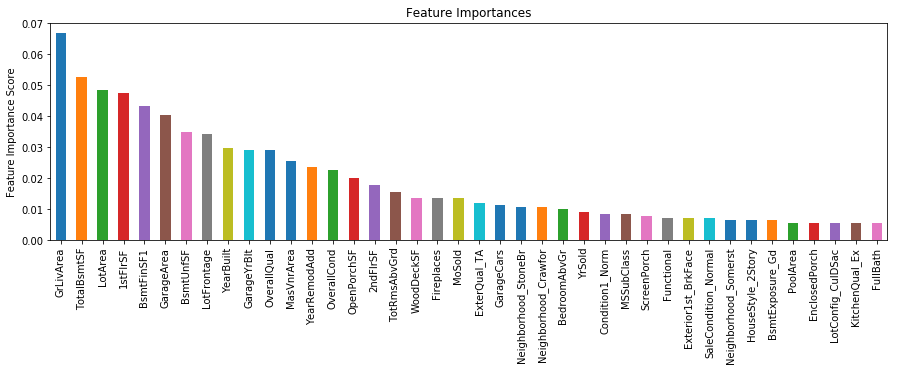

In [104]:
xgb3 = XGBRegressor( #classifier because of binary targer variable
        learning_rate =0.1, #default value (high)
        n_estimators=1000,  #NOT default (100)
        max_depth=3,        #OPTIMIZED 
        min_child_weight=2, #OPTIMIZED
        gamma=0,            #OPTIMIZED 
        subsample=0.5,      #OPTIMIZED 
        colsample_bytree=0.3,#OPTIMIZED 
        nthread=4,
        scale_pos_weight=1, #default
        random_state=27,    #Random number seed
        reg_alpha=530,      #OPTIMIZED 
        reg_lambda=1        #OPTIMIZED 
)    

modelfit(xgb3,train,predictors,target)

## Reducing learning rate
(and increasing the number of trees)

Cross-val results: 'n_estimators' = 3593

Model Report
Mean Absolute Error : 7168.06


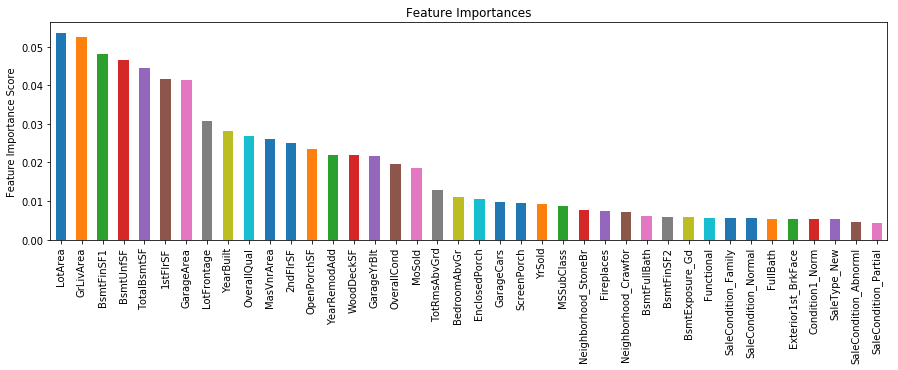

In [105]:
xgb4 = XGBRegressor( #classifier because of binary targer variable
        learning_rate =0.01, #default value (high)
        n_estimators=5000,  #NOT default (100)
        max_depth=3,        #OPTIMIZED 
        min_child_weight=2, #OPTIMIZED
        gamma=0,            #OPTIMIZED 
        subsample=0.5,      #OPTIMIZED 
        colsample_bytree=0.3,#OPTIMIZED 
        nthread=4,
        scale_pos_weight=1, #default
        random_state=27,    #Random number seed
        reg_alpha=530,      #OPTIMIZED 
        reg_lambda=1        #OPTIMIZED 
)    

modelfit(xgb4,train,predictors,target)